In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

/var/folders/90/k9tnl6dj03x59gg2bh329f_00000gn/T/ipykernel_43716/3245929106.py:8: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [29]:
# Run only once to save the account
# IBMProvider.save_account(token='bb476b01a013bc946f69aa946458459c1fbfb2d1e7716414275730e7be55934546bd36b7355e88842d961798995868389ff9d4ac2ddbec8f9b0ac541f45894ef', overwrite=True)

In [30]:
# Connect to the IBM's Quantum backend
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')
sampler = BackendSampler(backend)

In [31]:
# Set up a local simulator that mimics the real backend
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_sherbrooke")
# sampler = AerSimulator.from_backend(real_backend)

In [32]:
# check for active account
provider.active_account()

{'channel': 'ibm_quantum',
 'token': 'bb476b01a013bc946f69aa946458459c1fbfb2d1e7716414275730e7be55934546bd36b7355e88842d961798995868389ff9d4ac2ddbec8f9b0ac541f45894ef',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

MITIGATION EXPERIMENT SETUP

In [33]:
# Set up the mitigation experiment
qubits = [0,1,2]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)
exp2 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

         ░ ┌─┐      
   q_0: ─░─┤M├──────
         ░ └╥┘┌─┐   
   q_1: ─░──╫─┤M├───
         ░  ║ └╥┘┌─┐
   q_2: ─░──╫──╫─┤M├
         ░  ║  ║ └╥┘
meas: 3/════╩══╩══╩═
            0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        └───┘ ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
              ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
        ┌───┐ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
              ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
     

MZI EXPERIMENT SETUP


In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

In [9]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R')
phi_S = Parameter('phi_S')
theta = Parameter('theta')

In [10]:
# Create quantum registers & classical bits
qr_photon = QuantumRegister(1, 'path')
qr_polarize = QuantumRegister(1, 'polarization')
qr_absorb= QuantumRegister(1, 'absorption')
cr_detect = ClassicalRegister(1, 'abs_meas')
cr_polarizatoin = ClassicalRegister(1, 'plzn_meas')
cr_detector = ClassicalRegister(1, 'detector')

# Create a quantum circuit 
qc = QuantumCircuit(qr_photon, qr_polarize, qr_absorb, cr_detect, cr_polarizatoin, cr_detector)

# Polarization BS, creates a superposition and an entanglement with the polarization qubit
qc.h(0)
qc.cx(0,1)


# Polarizer on each path
qc.h(1)
qc.cz(0,1)
qc.h(2)
qc.cz(2,1)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.rz(phi_R-phi_S,0)
qc.barrier()

# 2nd BS
qc.cx(1,0)

# Polarizers at angle theta at Detectors
qc.ry(-2*theta,1)

# Measurement 
qc.barrier()
qc.measure([0,1,2],[2,1,0])

# Draw & save the circuit
circuit_image = qc.draw('mpl')
circuit_image.savefig("9.Double_PBS+Polarizer_on_Both_Paths+theta_Erasers_circuit.png", dpi=300)
qc.draw('mpl')

In [11]:
# Transpile the circuit
initial_layout = {qc.qubits[0]: 39, qc.qubits[1]: 40, qc.qubits[2]: 41}
qc_trans = transpile(qc, backend, initial_layout=initial_layout)

COMBINE CIRCUITS

In [12]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [13]:
bound_qc = [] 
exp1_qc = []
exp2_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
for i in range(2**num_qubits):
    initial_layout1 = {exp1.circuits()[i].qubits[0]: 39, exp1.circuits()[i].qubits[1]: 40, exp1.circuits()[i].qubits[2]: 41}
    initial_layout2 = {exp2.circuits()[i].qubits[0]: 39, exp2.circuits()[i].qubits[1]: 40, exp2.circuits()[i].qubits[2]: 41}
    trans_exp1_qc = transpile(exp1.circuits()[i], backend, initial_layout=initial_layout1)
    trans_exp2_qc = transpile(exp2.circuits()[i], backend, initial_layout=initial_layout2)
    exp1_qc.append(trans_exp1_qc)
    exp2_qc.append(trans_exp2_qc)

# Assign phase shift params from 0 to 2π & add the MZI circuits in the list
for j in range(6):
    for i in range(33):
        param_values = {phi_S: 0, phi_R: (pi/16)*i, theta: (pi/36)*j}
        bound_qc.append(qc_trans.assign_parameters(param_values))

# Combine all the circuits
all_qc = exp1_qc + bound_qc + exp2_qc
print(len(all_qc)) # Should be 214 in total = 8 prior mitigation circ + 33*6 MZI circ + 8 post mitigation circ

214


RUN THE EXPERIMENT

In [14]:
# Run on the real backend 
# job = sampler.run(all_qc, shots=shots)
# print(job.job_id())

RETRIEVE THE JOB

In [34]:
# Load first account
# IBMProvider.save_account(token='bb476b01a013bc946f69aa946458459c1fbfb2d1e7716414275730e7be55934546bd36b7355e88842d961798995868389ff9d4ac2ddbec8f9b0ac541f45894ef', overwrite=True)

In [35]:
# Define job id & retreive the job
job_id1 = 'ctn8qn64gzyg008zf90g'
job_id2 = 'ctqcja14gjh0008psem0'
job1 = QiskitRuntimeService().job(job_id1)
result1 = job1.result()
job2 = QiskitRuntimeService().job(job_id2)
result2 = job2.result()

In [45]:
# Load second account
IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186', overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')
sampler = BackendSampler(backend)

In [46]:
provider.active_account()

{'channel': 'ibm_quantum',
 'token': '27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

In [105]:
# Define job id & retreive the job
job_id3 = 'ctsxz0wv0kkg008prj4g'
job3 = QiskitRuntimeService().job(job_id3)
result3 = job3.result()

In [107]:
# Get Mitigation experitment results
exp_results1 = [result1.get_counts()[i] for i in range(2**num_qubits)]
exp_results2 = [result2.get_counts()[i] for i in range(2**num_qubits)]
exp_results3 = [result3.get_counts()[i] for i in range(2**num_qubits)]

# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['000','001', '010', '011', '100', '101', '110', '111']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator1 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp_results1))
mitigator2 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp_results2))
mitigator3 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp_results3))


# Get unmitigated counts
unmitigated_counts_raw1 = [result1.get_counts()[2**num_qubits+i] for i in range(99)]
unmitigated_counts1 = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw1]
unmitigated_counts_raw2 = [result2.get_counts()[2**num_qubits+i] for i in range(132)]
unmitigated_counts2 = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw2]
unmitigated_counts_raw3 = [result3.get_counts()[2**num_qubits+i] for i in range(33)]
unmitigated_counts3 = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw3]

SAVE DATA AS A CSV FILE

In [135]:
# import pandas as pd

# # Convert the counts to a pandas DataFrame
# exp1_df = pd.DataFrame(exp_results1)
# exp2_df = pd.DataFrame(exp_results2)
# exp3_df = pd.DataFrame(exp_results2)
# counts1_df = pd.DataFrame(unmitigated_counts1)
# counts2_df = pd.DataFrame(unmitigated_counts1)
# counts3_df = pd.DataFrame(unmitigated_counts1)

# # Add a column for the circuit number
# exp1_df['Circuit Number'] = range(1, len(exp1_df) + 1)
# exp2_df['Circuit Number'] = range(1, len(exp2_df) + 1)
# exp3_df['Circuit Number'] = range(1, len(exp2_df) + 1)
# counts1_df['Circuit Number'] = range(1, len(counts1_df) + 1)
# counts2_df['Circuit Number'] = range(1, len(counts2_df) + 1)
# counts3_df['Circuit Number'] = range(1, len(counts3_df) + 1)

# # Reorder the columns so that 'Circuit Number' comes first
# exp1_df = exp1_df[['Circuit Number', '000', '001', '010', '011', '100', '101', '110', '111']]
# exp2_df = exp2_df[['Circuit Number', '000', '001', '010', '011', '100', '101', '110', '111']]
# exp3_df = exp3_df[['Circuit Number', '000', '001', '010', '011', '100', '101', '110', '111']]
# counts1_df = counts1_df[['Circuit Number', '0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']]
# counts2_df = counts2_df[['Circuit Number', '0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']]
# counts3_df = counts3_df[['Circuit Number', '0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']]

# # Save the DataFrame to a CSV file
# exp1_df.to_csv('9.pre_mitigation_circ_count1(15,30,45).csv', index=False)
# exp2_df.to_csv('9.pre_mitigation_circ_count2(5,10,20,25).csv', index=False)
# exp3_df.to_csv('9.pre_mitigation_circ_count3(0).csv', index=False)
# counts1_df.to_csv('9.MZI_circ_counts1(15,30,45).csv', index=False)
# counts2_df.to_csv('9.MZI_circ_counts2(5,10,20,25).csv', index=False)
# counts2_df.to_csv('9.MZI_circ_counts3(0).csv', index=False)

DEFINE TWO MITIGATION METHODS

In [109]:
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator, unmitigated_counts):
    unmitigated_probs, mitigated_quasi_probs, mitigated_probs, mitigated_counts = [], [], [], []
    for i in range(len(unmitigated_counts)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts


# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator, unmitigated_counts):
    unmitigated_probs, mitigated_probs, mitigated_counts = [], [], []
    for i in range(len(unmitigated_counts)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0 0 0'], unmitigated_counts[i]['0 0 1'], unmitigated_counts[i]['0 1 0'], unmitigated_counts[i]['0 1 1'], 
                              unmitigated_counts[i]['1 0 0'], unmitigated_counts[i]['1 0 1'], unmitigated_counts[i]['1 1 0'], unmitigated_counts[i]['1 1 1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        total_count = 0
        for i in range(len(vec_count)):
            if mitigated_quasi_count[i] < 0:mitigated_quasi_count[i] = 0
            total_count += mitigated_quasi_count[i]
        # Define dictionaries
        dict_count = {
            '000': mitigated_quasi_count[0].item(),
            '001': mitigated_quasi_count[1].item(),
            '010': mitigated_quasi_count[2].item(),
            '011': mitigated_quasi_count[3].item(),
            '100': mitigated_quasi_count[4].item(),
            '101': mitigated_quasi_count[5].item(),
            '110': mitigated_quasi_count[6].item(),
            '111': mitigated_quasi_count[7].item()
        }
        dict_prob = {
            '000': (mitigated_quasi_count[0]/total_count).item(),
            '001': (mitigated_quasi_count[1]/total_count).item(),
            '010': (mitigated_quasi_count[2]/total_count).item(),
            '011': (mitigated_quasi_count[3]/total_count).item(),
            '100': (mitigated_quasi_count[4]/total_count).item(),
            '101': (mitigated_quasi_count[5]/total_count).item(),
            '110': (mitigated_quasi_count[6]/total_count).item(),
            '111': (mitigated_quasi_count[7]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts  

PRINT RESULT

Unmitigated Counts: 
{'1 1 0': 1390, '1 1 1': 1435, '1 0 1': 703, '0 0 0': 1449, '1 0 0': 670, '0 1 0': 489, '0 1 1': 488, '0 0 1': 1568}
Mitigated Counts: 
{'010': 474, '110': 480, '001': 659, '101': 699, '011': 1407, '000': 1444, '111': 1458, '100': 1570}

Unmitigated Prob: 
{'0 1 1': 0.169677734375, '1 1 1': 0.1751708984375, '1 0 1': 0.0858154296875, '0 0 0': 0.1768798828125, '0 0 1': 0.081787109375, '0 1 0': 0.0596923828125, '1 1 0': 0.0595703125, '1 0 0': 0.19140625}
Mitigated Prob: 
{'010': 0.05790753774223334, '110': 0.058621492631091336, '001': 0.08044930044874674, '101': 0.08532285236022373, '011': 0.17170754273260727, '000': 0.17632443366701034, '111': 0.17799333096875575, '100': 0.19167350944933143}


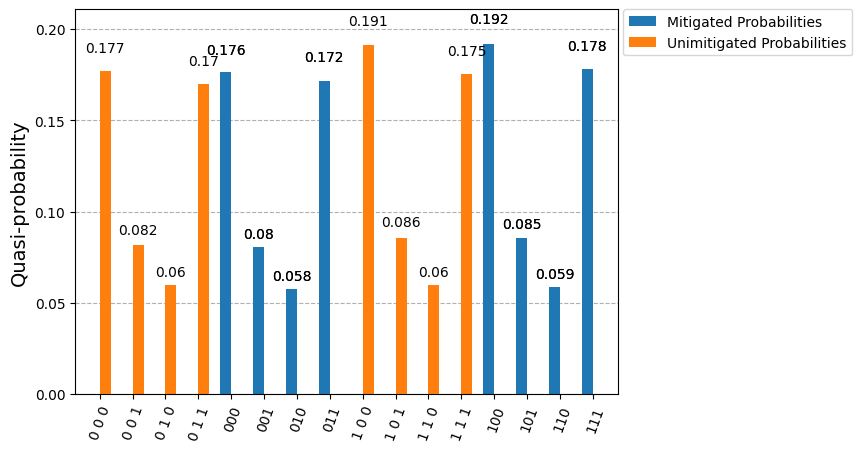

In [110]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
unmitigated_probs1, mitigated_probs1, mitigated_counts1 = mitigation_method_1(mitigator1, unmitigated_counts1)
unmitigated_probs2, mitigated_probs2, mitigated_counts2 = mitigation_method_1(mitigator2, unmitigated_counts2)
unmitigated_probs3, mitigated_probs3, mitigated_counts3 = mitigation_method_1(mitigator3, unmitigated_counts3)

# Index of a circuit [0:0π 1=π/2, 2=π, 3=3π/2]
i = 0

# Print unmitigated & mitigated counts and plot 

print("Unmitigated Counts: ")
print(unmitigated_counts1[i]) 
print("Mitigated Counts: ")
print(mitigated_counts1[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs1[i])
print("Mitigated Prob: ")
print(mitigated_probs1[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs1[i], unmitigated_probs1[i]], legend=legend)

SCATTER PLOT OVER ALL ANGLES

In [111]:
# Extract x, y data 
x = [(pi/16)*i for i in range(33)]
y_0_0 = [(d.get('000', 0)) for d in mitigated_probs3]
y_1_0 = [(d.get('100', 0)) for d in mitigated_probs3]
y_0_5 = [(d.get('000', 0)) for d in mitigated_probs2[:33]]
y_1_5 = [(d.get('100', 0)) for d in mitigated_probs2[:33]]
y_0_10 = [(d.get('000', 0)) for d in mitigated_probs2[33:66]]
y_1_10 = [(d.get('100', 0)) for d in mitigated_probs2[33:66]]
y_0_15 = [(d.get('000', 0)) for d in mitigated_probs1[:33]]
y_1_15 = [(d.get('100', 0)) for d in mitigated_probs1[:33]]
y_0_20 = [(d.get('000', 0)) for d in mitigated_probs2[66:99]]
y_1_20 = [(d.get('100', 0)) for d in mitigated_probs2[66:99]]
y_0_25 = [(d.get('000', 0)) for d in mitigated_probs2[99:132]]
y_1_25 = [(d.get('100', 0)) for d in mitigated_probs2[99:132]]
y_0_30 = [(d.get('000', 0)) for d in mitigated_probs1[33:66]]
y_1_30 = [(d.get('100', 0)) for d in mitigated_probs1[33:66]]
y_0_45 = [(d.get('000', 0)) for d in mitigated_probs1[66:99]]
y_1_45 = [(d.get('100', 0)) for d in mitigated_probs1[66:99]]

# Calculate standard error (SE = sqrt(p(1-p)/n)) measures how much the probability varies from the true probability.
y_err_0 = [np.sqrt(y_0_0[i] * y_1_0[i]/(mitigated_counts3[i].get('000',0) + mitigated_counts3[i].get('100',0)))*1.96 for i in range (33)]
y_err_5 = [np.sqrt(y_0_5[i] * y_1_5[i]/(mitigated_counts2[i].get('000',0) + mitigated_counts2[i].get('100',0)))*1.96 for i in range (33)]
y_err_10 = [np.sqrt(y_0_10[i] * y_1_10[i]/(mitigated_counts2[i+33].get('000',0) + mitigated_counts2[i+33].get('100',0)))*1.96 for i in range (33)]
y_err_15 = [np.sqrt(y_0_15[i] * y_1_15[i]/(mitigated_counts1[i].get('000',0) + mitigated_counts1[i].get('100',0)))*1.96 for i in range (33)]
y_err_20 = [np.sqrt(y_0_20[i] * y_1_20[i]/(mitigated_counts2[i+66].get('000',0) + mitigated_counts2[i+66].get('100',0)))*1.96 for i in range (33)]
y_err_25 = [np.sqrt(y_0_25[i] * y_1_25[i]/(mitigated_counts2[i+99].get('000',0) + mitigated_counts2[i+99].get('100',0)))*1.96 for i in range (33)]
y_err_30 = [np.sqrt(y_0_30[i] * y_1_30[i]/(mitigated_counts1[i+33].get('000',0) + mitigated_counts1[i+33].get('100',0)))*1.96 for i in range (33)]
y_err_45 = [np.sqrt(y_0_45[i] * y_1_45[i]/(mitigated_counts1[i+66].get('000',0) + mitigated_counts1[i+66].get('100',0)))*1.96 for i in range (33)]

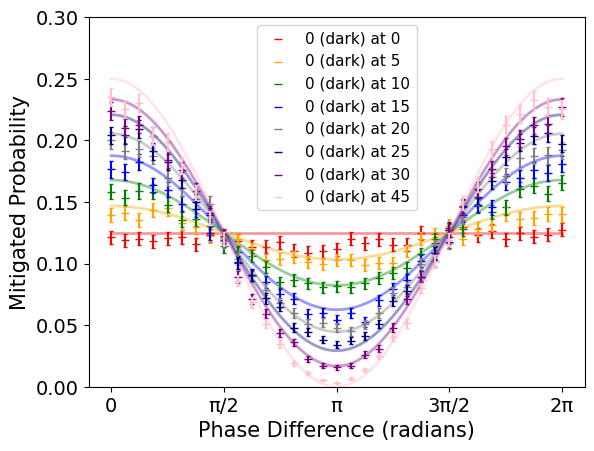

In [134]:
# Create a scatter plot
plt.figure()

# Theoretical graphs
theta = np.linspace(0, 2*np.pi, 1000)
zero = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(0))+1)
plt.plot(theta, zero, color='red', alpha=0.4, linewidth = 2)
five = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(5))+1)
plt.plot(theta, five, color='orange', alpha=0.4, linewidth = 2)
ten = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(10))+1)
plt.plot(theta, ten, color='green', alpha=0.4, linewidth = 2)
fifteen = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(15))+1)
plt.plot(theta, fifteen, color='blue', alpha=0.4, linewidth = 2)
twenty = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(20))+1)
plt.plot(theta, twenty, color='grey', alpha=0.4, linewidth = 2)
twentyfive = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(25))+1)
plt.plot(theta, twentyfive, color='navy', alpha=0.4, linewidth = 2)
thirty = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(30))+1)
plt.plot(theta, thirty, color='purple', alpha=0.4, linewidth = 2)
fourtyfive = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(45))+1)
plt.plot(theta, fourtyfive, color='pink', alpha=0.4, linewidth = 2)

plt.errorbar(x, y_0_0, color='red', yerr=y_err_0, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_0, color='red',label='0 (dark) at 0', marker="_", linewidths=1)
plt.errorbar(x, y_0_5, color='orange', yerr=y_err_5, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_5, color='orange', label='0 (dark) at 5', marker="_", linewidths=1)
plt.errorbar(x, y_0_10, color='green', yerr=y_err_10, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_10, color='green', label='0 (dark) at 10', marker="_", linewidths=1)
plt.errorbar(x, y_0_15, color='blue', yerr=y_err_15, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_15, color='blue', label='0 (dark) at 15', marker="_", linewidths=1)
plt.errorbar(x, y_0_20, color='grey', yerr=y_err_20, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_20, color='grey', label='0 (dark) at 20', marker="_", linewidths=1)
plt.errorbar(x, y_0_25, color='navy', yerr=y_err_25, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_25, color='navy', label='0 (dark) at 25', marker="_", linewidths=1)
plt.errorbar(x, y_0_30, color='purple', yerr=y_err_30, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_30, color='purple', label='0 (dark) at 30', marker="_", linewidths=1)
plt.errorbar(x, y_0_45, color='pink', yerr=y_err_45, capsize=1.7, linestyle="none")
plt.scatter(x,y_0_45, color='pink', label='0 (dark) at 45', marker="_", linewidths=1)


plt.xlabel('Phase Difference (radians)', size = 15)
tick_positions = [(pi/2)*i for i in range(5)]
tick_labels = ['0', 'π/2' , 'π', '3π/2', '2π']
plt.xticks(tick_positions, tick_labels, fontsize = 14)
plt.ylim(0,0.3)
plt.yticks(fontsize = 14)
plt.ylabel('Mitigated Probability', size = 15)
plt.legend(fontsize=11)
plt.savefig("9.Double_PBS+Polarizer_on_Both_Paths+theta_Erasers_0_result.png", dpi=300)
plt.show()


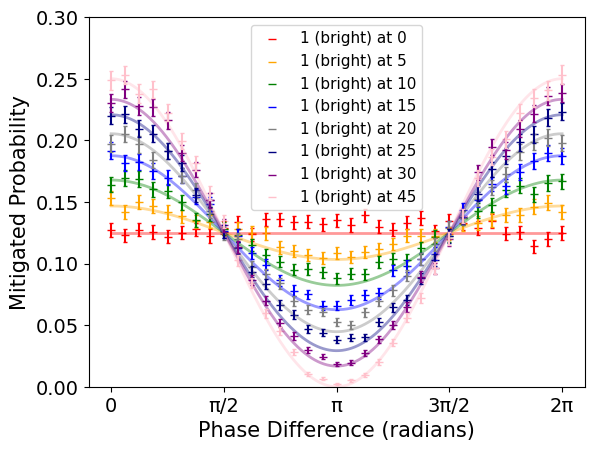

In [133]:
# Create a scatter plot
plt.figure()

# Theoretical graphs
theta = np.linspace(0, 2*np.pi, 1000)
zero = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(0))+1)
plt.plot(theta, zero, color='red', alpha=0.4, linewidth = 2)
five = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(5))+1)
plt.plot(theta, five, color='orange', alpha=0.4, linewidth = 2)
ten = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(10))+1)
plt.plot(theta, ten, color='green', alpha=0.4, linewidth = 2)
fifteen = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(15))+1)
plt.plot(theta, fifteen, color='blue', alpha=0.4, linewidth = 2)
twenty = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(20))+1)
plt.plot(theta, twenty, color='grey', alpha=0.4, linewidth = 2)
twentyfive = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(25))+1)
plt.plot(theta, twentyfive, color='navy', alpha=0.4, linewidth = 2)
thirty = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(30))+1)
plt.plot(theta, thirty, color='purple', alpha=0.4, linewidth = 2)
fourtyfive = 0.125*(np.cos(theta)*np.sin(2*np.deg2rad(45))+1)
plt.plot(theta, fourtyfive, color='pink', alpha=0.4, linewidth = 2)

plt.errorbar(x, y_1_0, color='red', yerr=y_err_0, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_0, color='red', label='1 (bright) at 0', marker="_", linewidths=1)
plt.errorbar(x, y_1_5, color='orange', yerr=y_err_5, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_5, color='orange', label='1 (bright) at 5', marker="_", linewidths=1)
plt.errorbar(x, y_1_10, color='green', yerr=y_err_10, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_10, color='green', label='1 (bright) at 10', marker="_", linewidths=1)
plt.errorbar(x, y_1_15, color='blue', yerr=y_err_15, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_15, color='blue', label='1 (bright) at 15', marker="_", linewidths=1)
plt.errorbar(x, y_1_20, color='grey', yerr=y_err_20, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_20, color='grey', label='1 (bright) at 20', marker="_", linewidths=1)
plt.errorbar(x, y_1_25, color='navy', yerr=y_err_25, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_25, color='navy', label='1 (bright) at 25', marker="_", linewidths=1)
plt.errorbar(x, y_1_30, color='purple', yerr=y_err_30, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_30, color='purple', label='1 (bright) at 30', marker="_", linewidths=1)
plt.errorbar(x, y_1_45, color='pink', yerr=y_err_45, capsize=1.7, linestyle="none")
plt.scatter(x,y_1_45, color='pink', label='1 (bright) at 45', marker="_", linewidths=1)


plt.xlabel('Phase Difference (radians)', size = 15)
tick_positions = [(pi/2)*i for i in range(5)]
tick_labels = ['0', 'π/2' , 'π', '3π/2', '2π']
plt.xticks(tick_positions, tick_labels, fontsize = 14)
plt.ylim(0,0.3)
plt.yticks(fontsize = 14)
plt.ylabel('Mitigated Probability', size = 15)
plt.legend(fontsize=11)
plt.savefig("9.Double_PBS+Polarizer_on_Both_Paths+theta_Erasers_1_result.png", dpi=300)
plt.show()